# Review: Natural Language Processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils, plot_help
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from os import path
import nltk

import re


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

%matplotlib inline

In [2]:
#modify read_limit and chunk_size parameters based on memory capacity
df = utils.chunk_loader('data/review.json', read_limit=1000)

In [3]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,ujmEBvifdJM6h6RLv4wQIg,0,2013-05-07 04:34:36,1,Q1sbwvVQXV2734tPgoKj4Q,1,Total bill for this horrible service? Over $8G...,6,hG7b0MtEbXx5QzbzE6C_VA
1,NZnhc2sEQy3RmzKTZnqtwQ,0,2017-01-14 21:30:33,0,GJXCdrto3ASJOqKeVWPi6Q,5,I *adore* Travis at the Hard Rock's new Kelly ...,0,yXQM5uF2jS6es16SJzNHfg
2,WTqjgwHlXbSFevF32_DJVw,0,2016-11-09 20:09:03,0,2TzJjDVDEuAW6MR5Vuc1ug,5,I have to say that this office really has it t...,3,n6-Gk65cPZL6Uz8qRm3NYw
3,ikCg8xy5JIg_NGPx-MSIDA,0,2018-01-09 20:56:38,0,yi0R0Ugj_xUx_Nek0-_Qig,5,Went in for a lunch. Steak sandwich was delici...,0,dacAIZ6fTM6mqwW5uxkskg
4,b1b1eb3uo-w561D0ZfCEiQ,0,2018-01-30 23:07:38,0,11a8sVPMUFtaC7_ABRkmtw,1,Today was my second out of three sessions I ha...,7,ssoyf2_x0EQMed6fgHeMyQ


In [4]:
#random review text
df['text'][90]

"Man, I love Toronto! Hiding in a strip mall on Overlea, find a dingy looking restaurant that serves up fantastic, cheap kabob...be warned regardless of when you come here you'll likely be waiting for a table as this place is always overrun with people...If you're a fan of perfectly grilled spicy meat, you must try this place out...now that I've been here I need to limit how many times I go here per month :)\n\nTake the drive out and have some kabob...if you don't own a car, borrow one or get a zipcar membership...totally worth it!"

In [5]:
#Combine all the reviews into one massive string
review_text_combined = " ".join(review for review in df['text'])
print ("There are {} words in the combination of all reviews.".format(len(review_text_combined)))

There are 653683 words in the combination of all reviews.


In [6]:
#get length of individual review
text_len = [len(x) for x in df['text']]

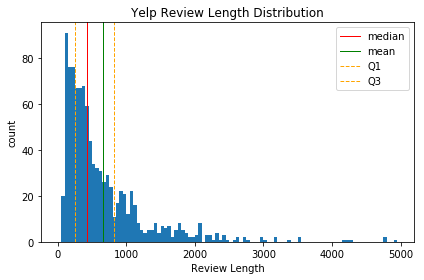

In [7]:
plot_help.plot_hist(pd.Series(text_len),end=5000, step=50,
                    feature='Review Length', xlabel='Review Length',
                    saveloc='plots/review_length.png')

### To Do List

We first assume that all the text stored will be in english. We need to convert the string representation of the text into a numeric representation that we can apply our machine learning algorithms to. We will assume that all the text given is in the English language and has minimal spelling errors. 

A list of steps that we need to do to the data:
- strip the text of all html formatting
- make everything lowercase
- find the importance of given words to the text


We can make use of french stop words in the future from here:<br>
[https://github.com/stopwords-iso/stopwords-fr](https://github.com/stopwords-iso/stopwords-fr)

In [8]:
with open('french_stop_words.txt') as f:
    french_stop_words = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
french_stop_words = [x.strip() for x in french_stop_words] 

### Text Overview

Create a word cloud to visualize what are the most common words in the corpus we are working on. Keep in mind that we might be working on a subset of the dataset given its size that might not fit on memory.

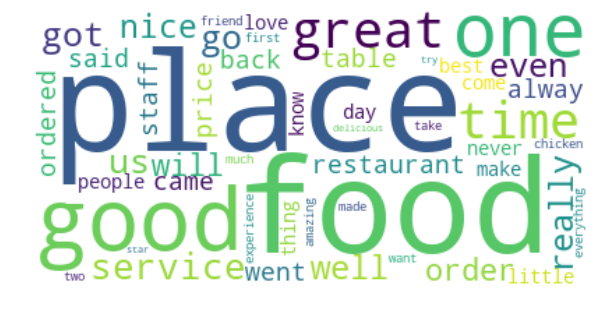

In [9]:
# Create stopword list:
stopwords = set(STOPWORDS)
#For now let's only remove the
stopwords.update(["the"])

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, 
                      background_color="white", 
                      width= 400, height = 200, 
                      max_words=50).generate(review_text_combined)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('plots/review_wordcloud.png')
plt.show()

### Text Data As Bag of Words

We achieve this with 3 steps:
- Tokenization
- Vocabulary building
- Encoding

In [10]:
#instantiate the countvectorizer and assume minimum frequenct is 3
vect = CountVectorizer(min_df=3, stop_words="english")

#fit the corpus
vect.fit(df['text'])


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [11]:
print("Vocab size = {}".format(len(vect.vocabulary_)))

Vocab size = 2784


In [12]:
#create bag of words
bag_of_words = vect.transform(df['text'])

In [13]:
#number of features to see
k=20
feature_names = vect.get_feature_names()
print("Number of features = {}".format(len(feature_names)))
print("First {} features: \n{}".format(k, feature_names[:k]))

Number of features = 2784
First 20 features: 
['00', '10', '100', '11', '12', '13', '14', '15', '150', '16', '17', '18', '1st', '20', '200', '22', '24', '25', '2nd', '30']


#### The first couple of features are all numbers and appear throughout the text, most of them seem to point to time.

### Rescale Data With tf-idf

We can rescale the features by how informative we expect them to be, we give high weight to words that appear often in a particular document but not in many documents.

In [14]:
def stem_sentences(sentence):
    
    """
    Helper function to stem text with PorterStemmber and Lemmatizer
    """
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer() 
    
    tokens = sentence.split()
    
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='n') for token in stemmed_tokens]
    lemmed_tokens = [lemmatizer.lemmatize(token, pos='v') for token in lemmed_tokens]
    
    return ' '.join(lemmed_tokens)

In [15]:
#french words to remove
fr_pat = r'\b(?:{})\b'.format('|'.join(french_stop_words))

#take out french words
text_no_fr = df['text'].str.replace(fr_pat, '')

#create a stemmed version of review text
text_stem = df['text'].apply(stem_sentences)

In [16]:
#instantiate tfidf object
tfidf = TfidfVectorizer(stop_words="english", min_df=2).fit(text_stem)

#transform and fit text
tfidf_text = tfidf.transform(text_stem)

In [17]:
#get feature array
feature_array = np.array(tfidf.get_feature_names())

#get sorted indeces
tfidf_sorting = np.argsort(tfidf_text.toarray()).flatten()[::-1]

k_tfidf = 20
print("{} features with HIGHEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][:k_tfidf]))
print("{} features with LOWEST tifdf: \n{}".format(k_tfidf, feature_array[tfidf_sorting][-k_tfidf:]))


20 features with HIGHEST tifdf: 
['ou' 'vou' 'et' 'que' 'pa' 'le' 'thé' 'ont' 'aux' 'sont' 'manger'
 'prendr' 'personnel' 'browni' 'trè' 'café' 'bon' 'est' 'pour' 'excellent']
20 features with LOWEST tifdf: 
['possibl' 'posit' 'portugues' 'portions' 'portion' 'pork' 'poppin'
 'polici' 'popcorn' 'pop' 'poorli' 'poor' 'pools' 'pool' 'pond' 'pomegran'
 'polite' 'polit' 'polish' '00']


### Notice that  we have french  words showing up! We might need to filter out french words by business_id zip